In [2]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, roc_curve


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


from tqdm.notebook import tqdm
import matplotlib.pyplot as plt             #visualisation
import seaborn as sns   #visualisation
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline     
sns.set(color_codes=True)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    raise Exception("Cry about it")


In [4]:
import torch.nn.functional as F
import math

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [5]:
def add_cell_prefix(df, prefix):
    df.index = [prefix + i for i in df.index]
    return df

#Remove extra quotes from the filenames
def extract_cell_name_smartseq(x):
    y = x.split("_")
    return y[len(y)-2]

def get_cell_name_smartseq(file_name):
    return extract_cell_name_smartseq(file_name)

def convert_indexes_to_cell_names_smartseq(df):
    df.index = [get_cell_name_smartseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_smartseq(df_meta, cell_name):
    return df_meta[df_meta["Cell name"]==cell_name]["Condition"].values[0]

def seperate_hypo_and_norm_smartseq(df, df_meta):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Hypo")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_smartseq(df_meta, x)=="Norm" or get_cell_hypo_or_norm_smartseq(df_meta, x)=="Normo")]
    return df_hypo, df_norm

def process_df_smartseq(df, df_meta, prefix):
    df = convert_indexes_to_cell_names_smartseq(df)
    _, df_norm = seperate_hypo_and_norm_smartseq(df,df_meta)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

#Remove extra quotes from the filenames
def extract_cell_name_dropseq(x):
    y = x.split("_")
    return y[0]

def get_cell_name_dropseq(file_name):
    return extract_cell_name_dropseq(file_name)

def convert_indexes_to_cell_names_dropseq(df):
    df.index = [get_cell_name_dropseq(x) for x in df.index]
    return df

def get_cell_hypo_or_norm_dropseq(cell_name):
    return cell_name.split("_")[-1]

def seperate_hypo_and_norm_dropseq(df):
    df_hypo = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Hypoxia")]
    df_norm = df[df.index.map(lambda x: get_cell_hypo_or_norm_dropseq(x)=="Normoxia")]
    return df_hypo, df_norm

def process_df_dropseq(df, prefix):
    _, df_norm = seperate_hypo_and_norm_dropseq(df)
    df = convert_indexes_to_cell_names_dropseq(df)
    df_norm = convert_indexes_to_cell_names_dropseq(df_norm)
    df = add_cell_prefix(df, prefix)
    df_norm = add_cell_prefix(df_norm, prefix)
    return df, df_norm.index

In [6]:
df_meta = pd.read_csv("Data/SmartSeq/MCF7_SmartS_MetaData.tsv",delimiter="\t", index_col=0)
dffn = pd.read_csv("Data/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df2_meta = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_MetaData.tsv",delimiter="\t",index_col=0)
df2fn = pd.read_csv("Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df3 = pd.read_csv("Data/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T
df4 = pd.read_csv("Data/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt",delimiter=" ",index_col=0).T

In [7]:
dffn, dffn_norm_idx = process_df_smartseq(dffn.copy(), df_meta, "MCF7_")
df2fn, df2fn_norm_idx = process_df_smartseq(df2fn.copy(), df2_meta, "HCC1806_")
df3, df3_norm_idx = process_df_dropseq(df3, "MCF7_")
df4, df4_norm_idx = process_df_dropseq(df4, "HCC1806_")

In [8]:
df3

,MALAT1,MT-RNR2,NEAT1,H1-5,TFF1,MT-RNR1,H4C3,GDF15,KRT81,MT-CO3,...,MROH1,SKIDA1,MICALL1,RARG,MYO1F,BRWD1-AS2,RPS19BP1,AUNIP,TNK2,SUDS3
MCF7_AAAAACCTATCG,1,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACAACCCTA,3,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACACTCTCA,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACCAGGCAC,6,2,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_AAAACCTAGCTC,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MCF7_TTTTCGCGTAGA,0,0,0,0,3,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_TTTTCGTCCGCT,1,0,0,0,4,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
MCF7_TTTTCTCCGGCT,0,0,0,1,2,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,1
MCF7_TTTTGTTCAAAG,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_drop_norm_idx = np.concatenate([df3_norm_idx, df4_norm_idx])
df_smart_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx])
df_smart_idx = np.concatenate([dffn.index, df2fn.index])

df_all = pd.concat([dffn, df2fn, df3, df4])
df_all = df_all.fillna(0)

df_all_norm_idx = np.concatenate([dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx])

df_MCF7_idx = [idx for idx in df_all.index if "MCF7" in idx]


In [10]:
df_all["mcf"] = ["MCF7" in idx for idx in df_all.index]
df_all["smart"] = [idx in df_smart_idx for idx in df_all.index]

In [11]:
df_all = df_all.astype(np.int32)

In [12]:
# Free up memory
del dffn, df2fn, df3, df4, dffn_norm_idx, df2fn_norm_idx, df3_norm_idx, df4_norm_idx, df_meta, df2_meta

In [21]:
class NNDataset(Dataset):
    def __init__(self, df, df_norm_idx):
        self.data = df.values  # Convert DataFrame to numpy array
        self.data_norm = df_norm_idx
        self.idx = df.index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        dat = self.data[index, :]
        x = torch.tensor(dat, dtype=torch.float32, device=device)
        y = torch.tensor(0 if self.idx[index] in self.data_norm else 1,  dtype=torch.float32, device=device)
        return x, y

# Define the architecture of the autoencoder
class MAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(MAE, self).__init__()
        
        # Store input dimension
        self.input_dim = input_dim

        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
        self.relu = nn.LeakyReLU()
        
    def encode(self, x):
        return self.relu(self.encoder(x))
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h), h, self.decoder.weight

In [14]:
@torch.no_grad
def measure_model_log(writer, model, data_loader, epoch):
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    if(np.isnan(y_pred_class).any()):
        print("Found nan, skipping evaluation")
        return 
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    writer.add_scalar("F1 Score", f1, epoch)
    writer.add_scalar("Recall", recall, epoch)
    writer.add_scalar("Accuracy", accuracy, epoch)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')

    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    fig = plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    writer.add_figure("Confusion Matrix", fig, epoch)

    fig = plt.figure(figsize = (12,7))
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    writer.add_figure("ROC Curve", fig, epoch)


@torch.no_grad
def measure_model(model, data_loader):
    plt.close()
    correct = 0
    total = 0
    y_pred = []
    y_pred_class = []
    y_true = []
    for inputs, labels in data_loader:
        outputs = model(inputs)
        predicted = nn.Sigmoid()(outputs[:, 0])
        total += labels.size(0)
        correct += (predicted.round() == labels).sum().item()
        y_pred_class.extend(predicted.cpu().round().numpy()) # Save Prediction
        y_pred.extend(predicted.cpu().numpy()) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
    # constant for classes
    classes = ('Normoxia', 'Hypoxia')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred_class)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    f1 = f1_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    accuracy = (correct / total)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print(f'Accuracy on test: {accuracy * 100}%')


In [15]:
input_dim = df_all.shape[1]
learning_rate = 1e-2

latent_dim = 3

test_amount = 0.2

In [16]:
df_train, df_test = train_test_split(df_all, test_size=test_amount, stratify=df_all.index.isin(df_all_norm_idx))

In [17]:
df_train_smart = df_train[[i in df_smart_idx for i in df_train.index]]
df_train_drop = df_train[[i not in df_smart_idx for i in df_train.index]]

dataset = NNDataset(df_train, df_all_norm_idx)
dataset_drop = NNDataset(df_train_drop, df_all_norm_idx)
dataset_smart = NNDataset(df_train_smart, df_all_norm_idx)

data_loader = DataLoader(dataset, batch_size=512, shuffle=True)
data_loader_drop = DataLoader(dataset_drop, batch_size=128, shuffle=True)
data_loader_smart = DataLoader(dataset_smart, batch_size=32, shuffle=True)

In [18]:
dataset_test = NNDataset(df_test, df_all_norm_idx)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

df_test_smart = df_test[[i in df_smart_idx for i in df_test.index]]
df_test_drop = df_test[[i not in df_smart_idx for i in df_test.index]]

dataset_test_smart = NNDataset(df_test_smart, df_smart_norm_idx)
dataset_test_drop = NNDataset(df_test_drop, df_drop_norm_idx)

test_loader_smart = DataLoader(dataset_test_smart, batch_size=64, shuffle=True)
test_loader_drop = DataLoader(dataset_test_drop, batch_size=64, shuffle=True)

In [22]:
# Define the model
model = MAE(input_dim, latent_dim).to(device)
writer = SummaryWriter()

In [23]:
lr_sgd = 1e-2
lr_adm = 1e-3
lr_ada = 1e-2
lr_admw = 1e-3
wd_admw = 1e-4

# Define the optimizer
sgd = optim.SGD(model.parameters(), lr=lr_sgd)
adm = optim.Adam(model.parameters(), lr=lr_adm)
ada = optim.Adagrad(model.parameters(), lr=lr_ada)
admw = optim.AdamW(model.parameters(), lr=lr_admw, weight_decay=wd_admw)

In [24]:
model

MAE(
  (encoder): Linear(in_features=8647, out_features=3, bias=True)
  (decoder): Linear(in_features=3, out_features=8647, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [25]:
train_config = [
    #[5, data_loader, admw],
    [10, data_loader, adm]
]

In [26]:
torch.autograd.set_detect_anomaly(True) 

In [28]:
total_epochs = 0
mseloss = nn.MSELoss()
I = torch.eye(input_dim).to(device)
def bceloss(yhat, y):
    return (F.binary_cross_entropy(F.sigmoid(yhat), y))

def mae_loss(W2, lambda_m):
    
    # Orthogonality constraint loss
    W2_T = W2.t()
    
    # Construct the matrix M
    diag_elements = torch.pow(W2.norm(dim=0), -2)
    M = torch.diag(diag_elements)

    orthogonality_term = W2 @ M @ W2_T
    orthogonality_term -= I
    orthogonality_loss = torch.norm(orthogonality_term, p='fro') ** 2
    
    # Combined loss
    total_loss = lambda_m * orthogonality_loss
    return total_loss


# Training loop
for segment in train_config:
    num_epochs = segment[0]
    data_loaderr = segment[1]
    optimizer = segment[2]
    epochs = tqdm(range(num_epochs))
    for epoch in epochs:
        subepochs = tqdm(data_loaderr, position=epoch)
        running_losses = np.array([0.0,0.0,0.0])
        for inputs, labels in subepochs:
            # Zero the parameter gradients
            optimizer.zero_grad()

            recon_batch, m, W2 = model(inputs)

            # Calculate the loss
            loss  = F.mse_loss(recon_batch, inputs)
            loss1 = mae_loss(W2, 0.01)
            loss2 = bceloss(m[:, 2], labels)
            
            loss.backward(retain_graph=True)
            loss1.backward(retain_graph=True)
            loss2.backward()

            running_losses[0] = loss.item()
            running_losses[1] = loss1.item()
            running_losses[2] = loss2.item()

            subepochs.set_description(f"Current loss: {running_losses/(subepochs.n + 1)}")
            #print(f"Loss: {MSE.item()}, {KLD.item()}, {TC.item()}", flush=True)
            optimizer.step()

        writer.add_scalar("Loss/train", np.sum(running_losses)/len(data_loader), epoch)
        print(f"Epoch {epoch+1}, Loss: {np.sum(running_losses)/len(data_loader)}: {running_losses/len(data_loader)}", flush=True)
        writer.flush()
        total_epochs += 1
        subepochs.reset()
        subepochs.n = 0

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 1, Loss: 40.11602828009375: [3.86140936e+01 1.49034526e+00 1.15893668e-02]


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 2, Loss: 73.38327612239739: [7.18813897e+01 1.49034816e+00 1.15382147e-02]


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 3, Loss: 45.93405506528657: [4.44324067e+01 1.49036276e+00 1.12855845e-02]


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 4, Loss: 1.50214866895614: [0.00208069 1.49040985 0.00965812]


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 5, Loss: 71.47914121068757: [6.99773749e+01 1.49044602e+00 1.13202868e-02]


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 6, Loss: 59.472004854473575: [5.79702233e+01 1.49043761e+00 1.13439858e-02]


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 7, Loss: 93.64385382779713: [9.21415931e+01 1.49041472e+00 1.18459658e-02]


  0%|          | 0/58 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
outputs = []
cell_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs.extend(nn.Sigmoid()(model.encoder(inputs)).cpu().numpy())
        cell_labels.extend(labels.cpu().numpy())

pred_df = pd.DataFrame(outputs)
pred_df["Condition"] = cell_labels

In [30]:
predd_df = pred_df[pred_df > -100]

In [31]:
predd_df.describe()

,0,1,2,Condition
count,7348.000000,7348.000000,7348.000000,7348.000000
mean,0.004129,0.140519,0.534918,0.488432
std,0.008763,0.123185,0.188251,0.499900
min,0.000000,0.000000,0.000000,0.000000
25%,0.000116,0.047539,0.393743,0.000000
50%,0.000742,0.105305,0.535524,0.000000
75%,0.003900,0.197074,0.687908,1.000000
max,0.122531,0.807579,0.939506,1.000000


In [32]:
import plotly.express as px
fig = px.scatter_3d(predd_df, x=0, y=1, z=2, color="Condition")
fig.show()

In [33]:
svm_train = []
svm_test = []
svm_labels_train = []
svm_labels_test = []
with torch.no_grad():
    svm_train = F.sigmoid(model.encode(torch.tensor(df_train.values, dtype=torch.float32, device=device))).cpu().numpy()
    svm_labels_train = df_train.index.isin(df_all_norm_idx)
    svm_test = F.sigmoid(model.encode(torch.tensor(df_test.values, dtype=torch.float32, device=device))).cpu().numpy()
    svm_labels_test = df_test.index.isin(df_all_norm_idx)

In [34]:
import plotly.express as px
fig = px.scatter_3d(svm_train, x=0, y=1, z=2, color="Condition", opacity=0.2)
fig.show()

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of [0, 1, 2] but received: Condition

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [61]:
total = len(svm_labels_train)
total_positive = np.sum(svm_labels_train)
total_negative = total - total_positive

scale_pos_weight = total_negative/total_positive

pipeline = Pipeline([
    ('sca', StandardScaler()),
    ('rdf', RandomForestClassifier())  # Placeholder for the classifier
])

param_grid = {
    'sca': ['passthrough', StandardScaler()],
    'rdf__n_estimators': [1, 2, 5, 10,11,12,13,14,15,16,17,18,19, 20, 50, 100, 200, 500, 700, 1000],
    #'rdf__scale_pos_weight': [scale_pos_weight, 1],
    #'rdf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #'rdf__C': [0.01, 0.1, 1, 5],
    #'rdf__gamma': ['scale', 'auto'],
}

search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy", n_jobs=-1, error_score="raise", verbose=10)
result = search.fit(svm_train, svm_labels_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 2/5; 1/40] START rdf__n_estimators=1, sca=passthrough.......................
[CV 3/5; 1/40] START rdf__n_estimators=1, sca=passthrough.......................
[CV 1/5; 2/40] START rdf__n_estimators=1, sca=StandardScaler()..................
[CV 5/5; 1/40] START rdf__n_estimators=1, sca=passthrough.......................
[CV 1/5; 1/40] START rdf__n_estimators=1, sca=passthrough.......................
[CV 2/5; 1/40] END rdf__n_estimators=1, sca=passthrough;, score=0.867 total time=   0.0s
[CV 3/5; 2/40] START rdf__n_estimators=1, sca=StandardScaler()..................
[CV 3/5; 3/40] START rdf__n_estimators=2, sca=passthrough.......................
[CV 2/5; 2/40] START rdf__n_estimators=1, sca=StandardScaler()..................
[CV 4/5; 1/40] START rdf__n_estimators=1, sca=passthrough.......................[CV 1/5; 2/40] END rdf__n_estimators=1, sca=StandardScaler();, score=0.871 total time=   0.0s

[CV 4/5; 3/40] START rdf__

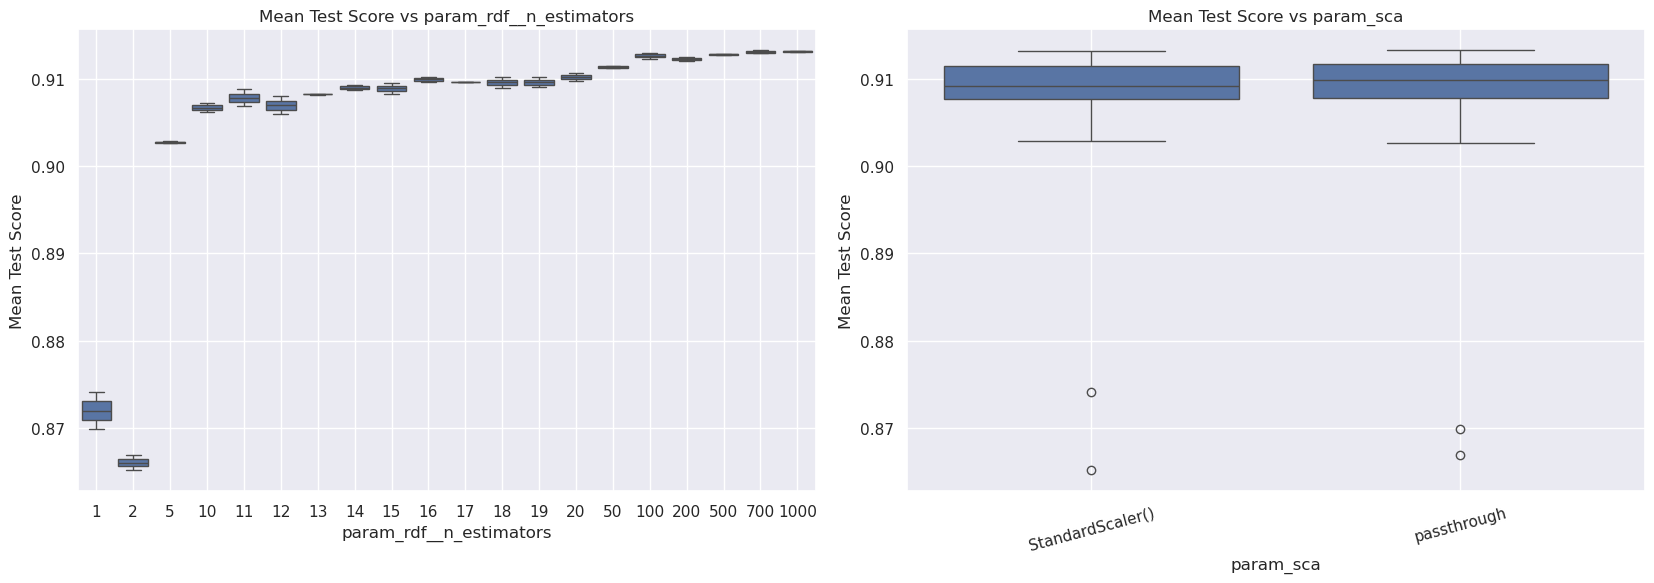

In [62]:
plot_search_results(result)

In [63]:
def plot_search_results(search_result):
    # Extract the results into a pandas DataFrame
    results = pd.DataFrame(search_result.cv_results_)
    
    # Extract parameter names
    param_names = [col for col in results.columns if col.startswith('param_')]
    
    # Determine grid size for subplots
    num_params = len(param_names)
    num_cols = 3
    num_rows = (num_params + num_cols - 1) // num_cols  # Ensure enough rows for all subplots
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, num_rows * 6))
    axs = axs.flatten()
    
    for i, param in enumerate(param_names):
        param_values = results[param]
        mean_test_score = results['mean_test_score']
        
        # Create a dataframe for table and compute average scores for unique parameter values
        table_data = pd.DataFrame({
            param: param_values,
            'mean_test_score': mean_test_score,
        })
        
        # Sort parameter values correctly if they are numerical
        try:
            table_data[param].fillna(-1, inplace=True)
            table_data[param] = table_data[param].astype(int)
        except (TypeError, ValueError):
            table_data[param] = table_data[param].astype(str)
        
        grouped_data = table_data.groupby(param).agg({
            'mean_test_score': list
        }).reset_index()
        
        grouped_data = grouped_data.sort_values(by=param)
        sorted_param_values = grouped_data[param].replace([-1, "-1"], "N/A")
        
        # Plot mean test score using boxplot
        sns.boxplot(x=sorted_param_values, y=grouped_data['mean_test_score'].explode(), ax=axs[i])
        axs[i].set_title(f'Mean Test Score vs {param}')
        axs[i].set_xlabel(param)
        axs[i].set_ylabel('Mean Test Score')
        axs[i].grid(True)
        
        # Rotate x-axis labels if they are strings
        if table_data[param].dtype == 'object':
            axs[i].set_xticks(range(len(sorted_param_values)))
            axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=15)
    
    # Remove any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

,precision,recall,f1-score,support
False,0.88,0.87,0.88,3589.00
True,0.88,0.89,0.88,3759.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.88,0.88,0.88,7348.00
weighted avg,0.88,0.88,0.88,7348.00


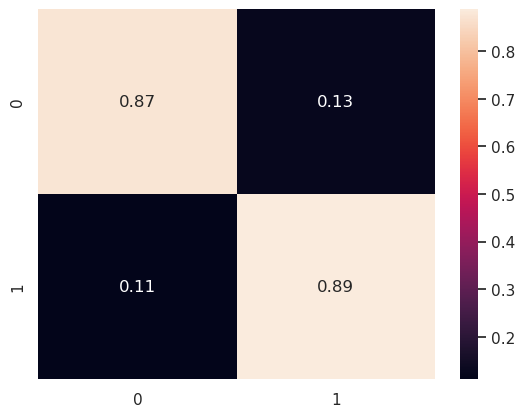

In [64]:
# Training with best parameters
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
best_model, best_params = result.best_estimator_, result.best_params_
best_model.fit(svm_train, svm_labels_train)
#y_best_pred_proba = best_model.predict_proba(svm_test)
y_best_pred = best_model.predict(svm_test)

cm = confusion_matrix(svm_labels_test, y_best_pred)
report = classification_report(svm_labels_test, y_best_pred, output_dict=True)


report_df = pd.DataFrame(report).transpose()    
styled_report = report_df.style.background_gradient().format(precision=2)
display(styled_report)

_ = sns.heatmap(cm / np.sum(cm, axis=1)[:, None], annot=True)

In [ ]:
torch.save(model.state_dict(), "NN_AE3.checkpoint")

In [ ]:
import gc

model.cpu()
del model, admw, ada, sgd, adm
gc.collect()
torch.cuda.empty_cache()